_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Names: FILL IN YOUR NAMES HERE

# Coding Lab 8

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex.

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone` poisson-GPFA from https://github.com/mackelab/poisson-gpfa and have the following directory structure:

```
├── data
├── poisson-gpfa
└── notebooks
    └── CodingLab8.ipynb
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nda_ex_8_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns
sns.set_context('paper')
sns.set(rc={'image.cmap': 'bwr'})
sns.set_style("whitegrid", {'axes.grid' : False})


# poisson-gpfa
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

*Grading: 3 pts*

In [2]:
# Initialize random number generator
# Specify dataset & fitting parameters
np.random.seed(42)
xdim      = 1  #latent dimensionality to fit
ydim      = 30 #number of neurons in the dataset
numTrials = 100		
trialDur  = 1000 # in ms
binSize   = 50	 # in ms
maxEMiter = 100		
dOffset   = 1.5	 # controls firing rate

# Sample from the model (make a toy dataset)
training_set  = util.dataset(
    seed      = 345533,
    xdim      = xdim,
	ydim      = ydim,
	numTrials = numTrials,
	trialDur  = trialDur,
	binSize   = binSize,
	dOffset   = dOffset,
	fixTau 	  = True, 
	fixedTau  = np.array([0.2]),
	drawSameX = False) 

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 46.415 Hz.


### Fit the model

In [3]:
# Initialize parameters using Poisson-PCA
initParams = util.initializeParams(xdim, ydim, training_set)

# insert your code here

fitToy = engine.PPGPFAfit(
# ------------------------------------
# Complete fitting the model (1 pt)
# ------------------------------------
    experiment = training_set,
    initParams = initParams,
    inferenceMethod = 'laplace',
    EMmode = 'Batch',
    maxEMiter = maxEMiter

)


Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = 13.7852
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [4]:
# some useful functions
def allTrialsState(fit,p):
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p,0])
    for i in range(len(fit.infRes['post_mean'])):
        x = np.concatenate((x,fit.infRes['post_mean'][i]),axis=1)
    return x

def allTrialsX(training_set):
    """Reshape the ground truth 
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt =  np.concatenate((x_gt,training_set.data[i]['X'][0]),axis = 0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [5]:
# All trials latent state vector
x_est = allTrialsState(fitToy,1)
x_true = allTrialsX(training_set)

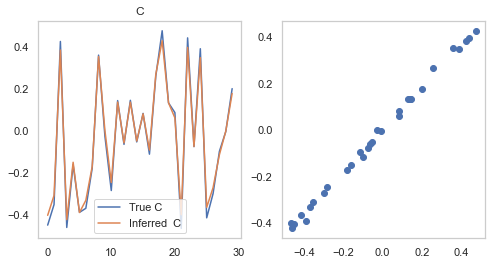

In [6]:
# ----------------------------------------------------
# Plot ground truth and inferred weights `C` (0.5 pts)
# ----------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.squeeze(-training_set.params["C"]), label="True C")
ax[0].plot(np.squeeze(fitToy.optimParams["C"]), label="Inferred  C")
ax[0].set_title("C")
ax[0].legend()

ax[1].scatter(-training_set.params["C"], fitToy.optimParams["C"])


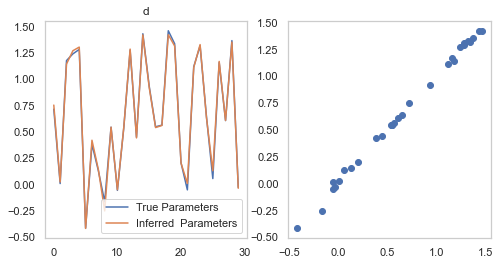

In [7]:
# ---------------------------------------------------
# Plot ground truth and inferred baises `d` (0.5 pts)
# ---------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.squeeze(training_set.params["d"]), label="True Parameters")
ax[0].plot(np.squeeze(fitToy.optimParams["d"]), label="Inferred  Parameters")
ax[0].set_title("d")
ax[0].legend()

ax[1].scatter(training_set.params["d"], fitToy.optimParams["d"])


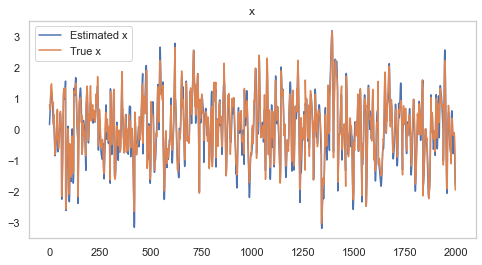

In [8]:
# ------------------------------------------------------
# Plot ground truth and inferred latent states `x` (1pt)
# ------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(np.squeeze(-x_est), label="Estimated x")
plt.plot(np.squeeze(x_true), label="True x")
plt.title("x")
plt.legend()


## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 2 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [9]:
class EckerDataset():
    """Loosy class"""
    def __init__(
        self,
        path,
        subject_id=0,
        ydim = 55,
        trialDur = 2000,
        binSize = 100,
        numTrials = 100,
        ydimData = False,
        numTrData = True):
        
#         T = binSize #int(trialDur/binSize)
        T = int(trialDur/binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time =matdat['spikeTimes'][:,trial_id][0] 
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)         
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append({
                'Y': matdat['spikeCounts'][:,:,trial_id],
                'spike_time': matdat['spikeTimes'][:,trial_id]})
        self.T = T
        self.trial_durs = trial_durs    
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim              
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [10]:
path = '../data/nda_ex_8_data.mat'
data = EckerDataset(path)


### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the mean-squared error on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

In [11]:
# insert your code here (1 pt)

cv = util.crossValidation(
    experiment = data,
    numTrainingTrials = 80,
    numTestTrials = 20,
    maxXdim = 5,
    maxEMiter = 3,
    batchSize = 5,
    inferenceMethod = 'laplace',
    learningMethod = 'batch')

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                    3 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:   3 of   3, nPLL: = -399.2860Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the mean-squared error of a constant rate model (or Poisson likelihood if you did the optional part above).

In [210]:
initParams = util.initializeParams(1, ydim, data)

# insert your code here

fitreal = engine.PPGPFAfit(
# ------------------------------------
# Complete fitting the model (1 pt)
# ------------------------------------
    experiment = data,
    initParams = initParams,
    inferenceMethod = 'laplace',
    EMmode = 'Batch',
    maxEMiter = maxEMiter
)



Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -379.1691

In [244]:
train.data[0]['Y'].shape

(55, 20)

In [12]:
train, test = util.splitTrainingTestDataset(data, numTrainingTrials = 80, numTestTrials = 20)
train_data = np.empty((0, 55,20))

for t in np.arange(80):
    for n in np.arange(train.ydim):
        train_data = np.append(train_data, train.data[t]['Y'][np.newaxis,:,:], axis=0)
    
    
train_mean = np.mean(train_data, axis=0)#.shape
print(f"Training set has shape: {train_mean.shape}")
train_err = []
for t in np.arange(20):
    for n in np.arange(test.ydim):
        err = test.data[t]['Y'][n] - train_mean[n,:]
        train_err = np.append(train_err, err@err)
train_err = np.sum(train_err)


Training set has shape: (55, 20)


Text(0.5, 1.0, 'Error by Dimensionality of Latent State')

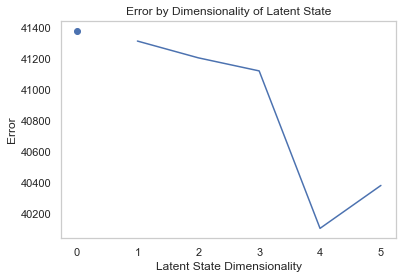

In [13]:
# insert your code here (1 pt)
plt.plot(np.arange(1,6), cv.errs)
plt.scatter(0,train_err)
plt.xlabel("Latent State Dimensionality")
plt.ylabel("Error")
plt.title("Error by Dimensionality of Latent State")
#plt.plot(cv_nolat.errs)

## Task 3. Visualization: population rasters and latent state. Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

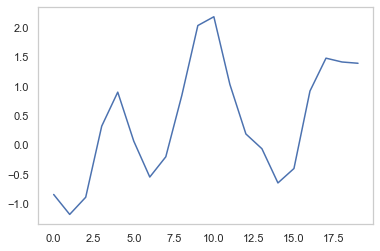

In [14]:
plt.plot(-cv.fits[0].infRes['post_mean'][0].T);

In [58]:
# for t in np.arange(20):
#     plt.figure(figsize=(4,1))
#     for i in np.arange(data.ydim):
#         if np.any(np.squeeze(data.data[t]["spike_time"][sortidx[i]]).shape):
#             lineshape = np.repeat(i, np.squeeze(data.data[t]["spike_time"][sortidx[i]]).shape[0])
#             plt.plot(np.squeeze(data.data[t]["spike_time"][sortidx[i]]), lineshape,"k.", markersize=2)

In [57]:


# plt.figure(figsize=(7, 14))
# for t in np.arange(20):
#     plt.subplot(10,2, t +1)
#     plt.imshow(np.squeeze(data.data[t]['Y'][np.flip(sortidx),:]), 
#                  interpolation = "nearest", aspect = 'auto', cmap = 'gray_r', extent=[0, 20, -5, 5])
#     plt.plot(-cv.fits[0].infRes["post_mean"][t].T)

# plt.tight_layout()

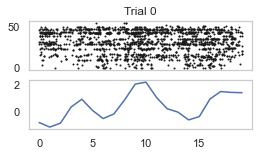

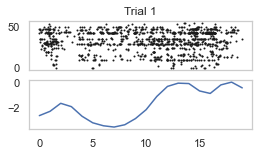

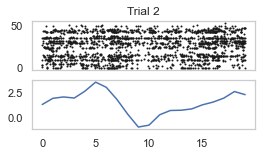

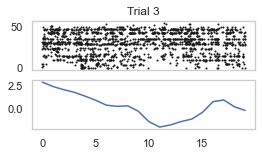

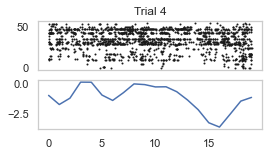

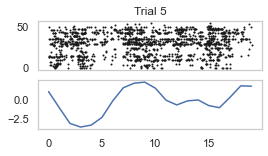

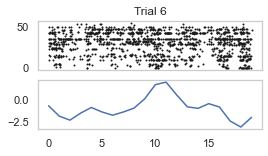

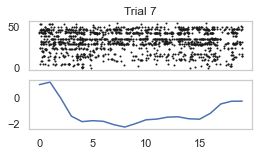

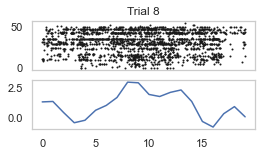

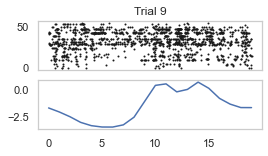

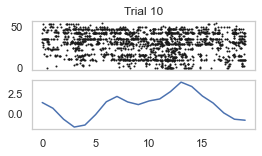

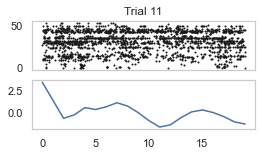

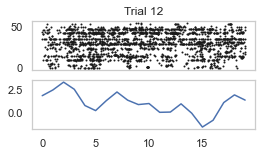

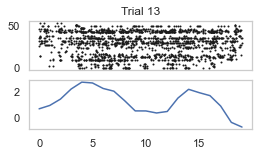

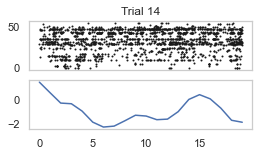

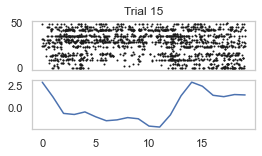

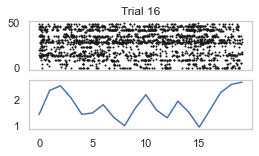

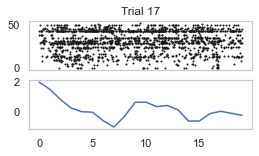

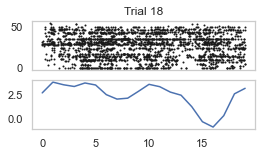

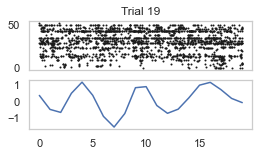

In [61]:
# braucht noch richtige x-Achse
sortidx = np.argsort(np.squeeze(cv.fits[0].optimParams["C"]))
for t in np.arange(20):
    fig, ax = plt.subplots(2, 1, figsize=(4, 2))
    for i in np.arange(55):
        this_line = data.data[t]['spike_time'][sortidx[i]]
        if np.any(this_line):
            ax[0].plot(this_line, np.repeat(i, this_line.shape[0]), "k.", markersize=2)
    ax[1].plot(-cv.fits[0].infRes["post_mean"][t].T)
    ax[0].set_title(f"Trial {t}")

In [180]:
# def plotTrajectory(model, dataset, trialToShow = 0):
#         '''
#         Plots ground truth latent trajectory, spike counts, parameters
#         '''
#         fig1, (ax0,ax1) = plt.subplots(nrows = 2, sharex = True, figsize = (5,4))
#         sortidx = np.argsort(model.optimParams["C"])
#         raster = ax0.imshow(np.squeeze(dataset.data[trialToShow]['Y'][sortidx,:]), 
#             interpolation = "nearest", aspect = 'auto', cmap = 'gray_r')
#         # raster.set_cmap('spectral')
#         ax0.set_ylabel('Neuron Index')
#         ax0.set_title('Binned Spike Counts')
#         ax1.plot(range(dataset.T),dataset.data[trialToShow]['X'].T,linewidth=2)
#         ax1.set_xlabel('Time ('+str(dataset.T)+' ms bins)')
#         ax1.set_title('Ground Truth Latent Trajectory')
#         ax1.set_xlim([0,dataset.T])
#         ax1.grid(which='both')
#         plt.tight_layout()


In [59]:
# for i in np.arange(20):
#     cv.fits[0].plotTrajectory(i)
#     plt.title(f"Trial {i}")

In [60]:
# insert your code here (2 pts)
# training_set.plotTrajectory()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\mu^T \exp(CC^T)+\text{ diag}(\mu) - \mu\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

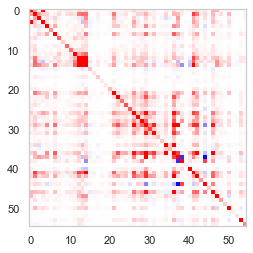

In [83]:
# insert your code here

# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of 
# the approximation using the provided equations (2 pts)
# --------------------------------------------------------------
def cov(fit):
    ctrans = np.diag(fit.optimParams["C"]*fit.optimParams["C"].T)
    mean = np.exp(0.5*ctrans) + fit.optimParams["d"]
    cov = mean*mean.T*np.exp(ctrans) + np.diag(mean) - mean*mean.T
    return cov
   
c = np.cov(data.all_raster)
plt.imshow(c, interpolation="nearest",cmap ='bwr',vmin = -1,vmax = 1)
#plt.imshow(cov(cv.fits[0]), interpolation="nearest",cmap ='bwr',vmin = -1,vmax = 1)
#np.diag(np.dot(cv.fits[0].optimParams["C"], cv.fits[0].optimParams["C"].T))
# --------------------------------------------------------------
# Plot the covariance matrix (1 pt) of 
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# --------------------------------------------------------------